# Guidelines

This notebook is a template of what could be explored. You can follow it and explore additional things.

Use the notebook to add your comments, figures, .... You can remove what you want and reorganize it as you wish. The goal is for you to make a nice report. The important points are to:

- understand what you will write
- explain the experimental results
- the code should be clean and well documented
- when you copy many times the same code, take the time to create a function instead.
- ideally, all the given text and code cells would be replaced by yours


# Autoencoders

An autoencoder (**AE**) is a special type of neural network that is trained to copy its input to its output. The key point is that between the input and output, there is a bottleneck: the dimension is reduced, and the information compressed.

For an input (image, time series, ... ), the autoencoder first encodes it into a lower dimensional latent representation (the bottleneck), then decodes this latent representation go recover the original input. Of course, in the middle you have a compression of the information, and the task is not trivial. The encoder and decoder are usually a neural architecture adapted to the data and their structure: convolution, recurrent, .... In most of the case, the decoder is as symmetric as possible of the encoder, but it is not mandatory.

An autoencoder learns to compress the data while minimizing the reconstruction error. This is an example of unsupervised learning. Autoencoder can be used to learn representation (the by product of the encoder), and to detect anomalies.

An autoencoder consists in two blocks:

- the encoder takes the input and projects it in a latent space of "reduced" dimension (in comparison with the input).
- the decoder maps some latent representation back in the input space.
  You can see these two steps as a compression and decompression.

Basically, if you consider an input $\mathbf{x}$ :
$$\mathbf{z} = encoder(\mathbf{x})$$
$$\mathbf{\tilde{x}} = decoder(\mathbf{z})$$

The goal is to train the AE. The goal is to minimize the reconstruction error. This error can be defined as the mean square error :
$$\min||\mathbf{\tilde{x}}-\mathbf{x}||^2$$

For this lab session, you will work with time series. One time serie is an electrocardiogram or ECG for short. It measures the electrical activities of the heart.
Each ECG corresponds to an extracted heartbeat containing 140 points and has been labelled as normal or being indicative of heart conditions related to congestive heart failure.

The goal is:

- from a set of ECGs (training set), we will train and AE on normal signals;
- and try to detect anomalies on unseen ECGs (test set) which contains normal and anormal ECGs.

## Anomaly detection

Autoencoders can learn to represent the data in a latent representation space and to reconstruct the data from this compressed representation. One possible application of AE is anomaly detection. The method is simple:

- if you encode and decode an input similar to the training data, the reconstruction loss should be low, while
- if you do the same with an input that differs from the training set, the loss should be higher (the model will fail to recontruct something similar).

Assume we have a dataset. In our, case we consider only the training ECGs that are normal. Then we want to detect anomalies in the test set. The AE is a simple yet efficient tool to achieve anomaly detection. The reconstruction error should be high if it is an anomalie and low otherwise. Basically, we need to define a threshold on the reconstruction error to decide whether the input is an anomaly or not.

Before experimenting these kind of applications. Let us build and explore AEs.

# Initialization of session

imports and dataset.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Download the dataset
PATH_TO_DATA = "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv"
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


Look at the data, explore them to look what they look like. For instance, the last value (number 140):


In [3]:
TARGET = 140  # The last (141'st) value is in fact the class.
# 1 for normal / 0 for bad ones

features = data.drop(TARGET, axis=1)
target = data[TARGET]


# With SKlearn, do a split in test and train
all_x_train, all_x_test, all_y_train, all_y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

# The use case is anomaly detection so use only the normal data
# for training
good_idx = all_y_train[all_y_train == 1].index
bad_idx = all_y_train[all_y_train == 0].index
x_train = all_x_train.loc[good_idx]
bad_x_train = all_x_train.loc[bad_idx]
# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train = th.tensor(min_max_scaler.fit_transform(x_train)).float()
bad_x_train = min_max_scaler.transform(bad_x_train)
x_test = min_max_scaler.transform(all_x_test)

We can plot some signals to see what they look like (normal and not normal)


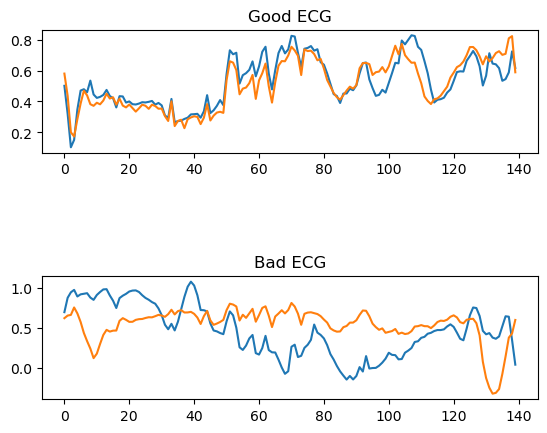

In [4]:
I, J = 0, 2
fig, axs = plt.subplots(2)
fig.subplots_adjust(hspace=1)  # increase the vertical space to better see the title
for i in range(I, J):
    axs[0].plot(x_train[i])
    axs[1].plot(bad_x_train[i])
_ = axs[0].set_title("Good ECG")
_ = axs[1].set_title("Bad ECG")

# First try : Simple Auto-encoder

The basic idea is to have a linear transformation followed by a non-linearity for both the encoder and decoder. Here it is possible, since all the time series are of the same length.

Some questions remain:

- For the output activation, what can we use as function ?
- Find the adapted loss (as define above).
- The only hyperparameter on the architecture is the dimension of the latent space: $h$. Can you define the possible range of $h$ ?

**TODO** Write a class for the encoder and test it on some training data as sanity-check. The idea is to define a class where we will have two
"blocks": the encoder and the decoder. The encoder is a simple Linear layer followed by a non-linearity (like Relu for instance). The decoder is also a Linear Layer but followed by an adapted activation. The important hyper-parameter here is $h$. It should be a parameter given to the constructor.

### Answer

The value of the hyperparameter h can varies from 1 dimension to as many as we want, but it causes an increase in the computation time.


In [5]:
### write the class
class SimpleAE(nn.Module):
    def __init__(self, input_size, h):
        super(SimpleAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_size, h), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(h, input_size), nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

**TODO** Write a function that train the autoencoder:

- for one model
- with some training data
- for some epochs
- with Adam and a tuneable learning rate.

**TODO**:

- Then use this function to train the AE and look at some reconstructions to see the results. Start with a hidden dimension of $10$.
- Take the test set and look at the reconstruction error of normal ECGs and bad ones.
- Build an histogram of the reconstruction errors get on the test set: - both classes on the same histogram - two different colors for each class.
  Given this histogram, can you guess the what could be the threshold and the expected error.

* Don't forget to try different value of the learning rate **for all the experiments now and after !**


In [6]:
# Global variables

Ntrain = x_train.shape[0]  # Number of train set
Nvalid = x_test.shape[0]  # Number of test set

In [7]:
# Loss function
def loss_fn(model, data):
    func = nn.MSELoss()
    output_data = model(data)
    return func(output_data, data)

In [8]:
# train function
def train(model, epochs=10, verbose=False):
    for i in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, x_train)  # compute the loss
        loss.backward()  # Back propagation
        optimizer.step()  # update the parameters

In [9]:
def test_histogram(model, lr, ax):
    # Preparation of data
    good_idx_test = all_y_test[all_y_test == 1].index
    bad_idx_test = all_y_test[all_y_test == 0].index
    x_test_good = th.tensor(
        min_max_scaler.transform(all_x_test.loc[good_idx_test])
    ).float()
    x_test_bad = th.tensor(
        min_max_scaler.transform(all_x_test.loc[bad_idx_test])
    ).float()

    loss_good = th.ones(x_test_good.shape[0])
    loss_bad = th.ones(x_test_bad.shape[0])

    # Calcul of loss for each sample :
    for i in range(x_test_good.shape[0]):
        loss_good[i] = loss_fn(model, x_test_good[i])
    for i in range(x_test_bad.shape[0]):
        loss_bad[i] = loss_fn(model, x_test_bad[i])

    # Histogram of reconstructed error for good ecg and bad ecg :
    ax.set_title(f"MCE Loss for reconstructed data\nLearning rate = {lr}")
    ax.hist(
        loss_good.detach().numpy(),
        bins=50,
        alpha=0.5,
        color="blue",
        label="Normal ECGs",
    )
    ax.hist(
        loss_bad.detach().numpy(), bins=50, alpha=0.5, color="red", label="Bad ECGs"
    )
    ax.set_xlabel("Reconstruction Error")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.minorticks_on()

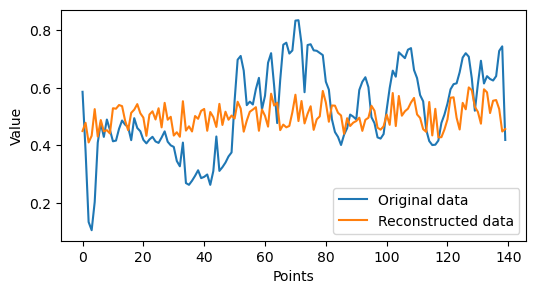

In [10]:
model = SimpleAE(input_size=x_train.shape[1], h=10)
lr = 0.01

optimizer = th.optim.Adam(model.parameters(), lr=lr)
train(model, epochs=10)
output = model(x_train[10])
plt.rcParams.update({"figure.figsize": (6, 3)})
plt.plot(x_train[10].detach().numpy(), label="Original data")
plt.plot(output.detach().numpy(), label="Reconstructed data")
plt.xlabel("Points")
plt.ylabel("Value")
plt.legend()

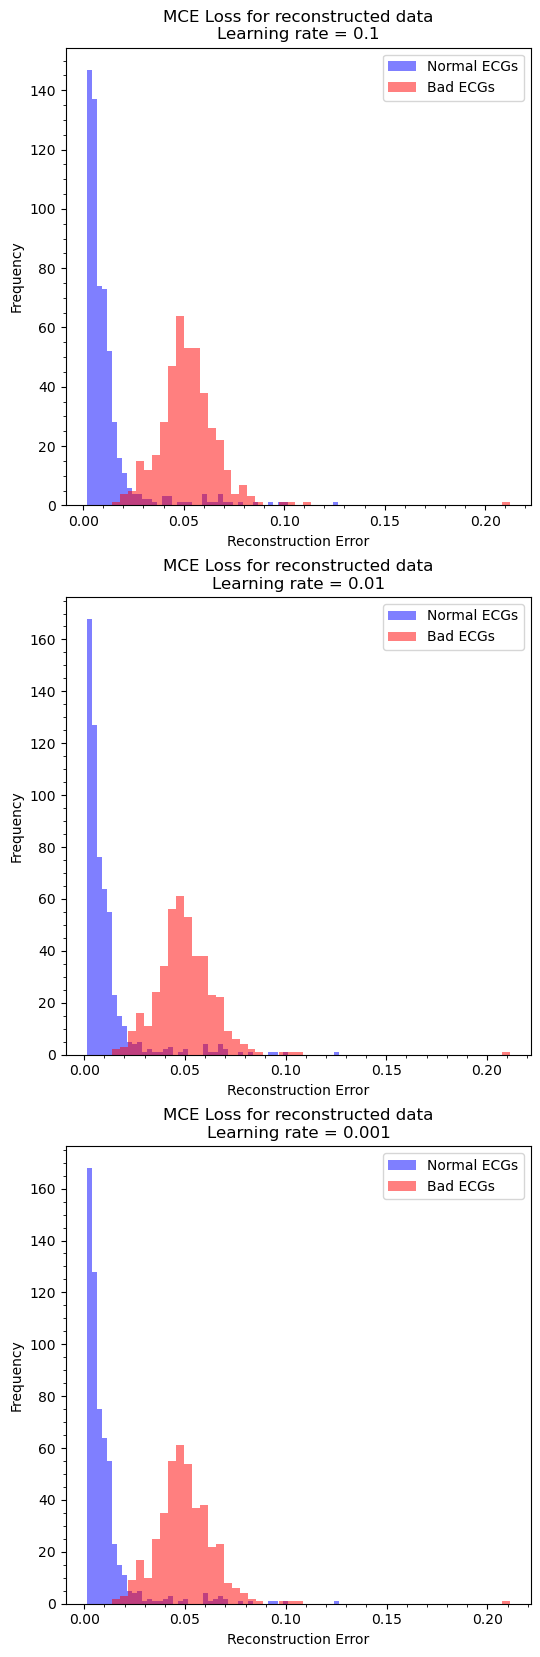

In [11]:
model = SimpleAE(input_size=x_train.shape[1], h=10)
plt.rcParams.update({"figure.figsize": (6, 4)})
lr = [0.1, 0.01, 0.001]
fig, ax = plt.subplots(3, 1)
plt.subplots_adjust(top=4)
for i in range(3):
    optimizer = th.optim.Adam(model.parameters(), lr=lr[i])
    train(model, epochs=10)
    test_histogram(model, lr[i], ax[i])

We successfully discriminated the good and bad ECGs. Based on histograms, we can determine what should be the reconstruction error threshold to choose the delimitation between good and bad ECG. We can model the histogram of bad ECGs with a gaussian distribution and set the threshold with a 1% error based on the left limit of the gaussian distribution. It should give for each histogram upperwards a reconstruction error threshold around 0.02.

We must be aware that there is a non negligeable amount of good ECGs with a reconstruction error superior to 0.02.

Let's compute it :


In [12]:
model = SimpleAE(input_size=x_train.shape[1], h=10)
# Train you model !
lr = 0.01
optimizer = th.optim.Adam(model.parameters(), lr=0.01)
train(model, epochs=10)

# Preparation of data
good_idx_test = all_y_test[all_y_test == 1].index
bad_idx_test = all_y_test[all_y_test == 0].index
x_test_good = th.tensor(min_max_scaler.transform(all_x_test.loc[good_idx_test])).float()
x_test_bad = th.tensor(min_max_scaler.transform(all_x_test.loc[bad_idx_test])).float()

loss_good = th.ones(x_test_good.shape[0])
loss_bad = th.ones(x_test_bad.shape[0])

# Calcul of loss for each sample :
for i in range(x_test_good.shape[0]):
    loss_good[i] = loss_fn(model, x_test_good[i])
for i in range(x_test_bad.shape[0]):
    loss_bad[i] = loss_fn(model, x_test_bad[i])

threshold = 0.02

count_good_a = (loss_good < threshold).sum().item()  # Number of good ECGs accepted
count_bad_a = (loss_bad < threshold).sum().item()  # Number of bad ECGs accepted
count_good_r = (loss_good > threshold).sum().item()  # Number of good ECGs refused
count_bad_r = (loss_bad > threshold).sum().item()  # Number of bad ECGs refused


P_G_i_Gc = (
    count_good_a / Nvalid
)  # Probability to be classed normal ECGs and to be normal ECGs
P_B_i_Bc = count_bad_r / Nvalid  # Probability to be classed bad ECGs and to be bad ECGs
P_G_i_Bc = (
    count_good_r / Nvalid
)  # Probability to be classed bad ECGs and to be good ECGs
P_B_i_Gc = (
    count_bad_a / Nvalid
)  # Probability to be classed good ECGs and to be bad ECGs

print(f"Percentage of errors : {100*(P_G_i_Bc + P_B_i_Gc):2.1f}%")
print(f"Percentage of well classified : {100*(P_G_i_Gc + P_B_i_Bc):2.1f}%\n")

print(
    f"Percentage of bad EGCs classed good : {100*(count_bad_a/x_test_bad.shape[0]):2.1f}%"
)
print(
    f"Percentage of good EGCs classed bad : {100*(count_good_r/x_test_good.shape[0]):2.1f}%"
)

Percentage of errors : 11.7%
Percentage of well classified : 88.3%

Percentage of bad EGCs classed good : 0.2%
Percentage of good EGCs classed bad : 19.9%


Percentage of errors : 24.6%  
Percentage of well classified : 75.4%

Percentage of bad EGCs classed good : 0.0%  
Percentage of good EGCs classed bad : 42.1%

We see that it is not a perfect classification and effort must be made to differentiate more the two sets. Using more hidden layers could be a solution, or changing the encoder/decoder function. We will see that in the following parts.

The threshold is the important parameter here : if we put it too high, a lot of bad EGCs will pass and if you put it too low, a lot of good EGCs will be considered as good


## Increase the dimension of the latent representation

**TODO**
Try different sizes : 10 and 50. For a qualitative evaluation, you can take some randomly selected training data:


In [13]:
imids = np.random.choice(x_train.shape[0], 5)

And for these ECGs, plot the original and their reconstructions, syde by side. You can also evaluate your autoencoder with the reconstruction error measured on the test set (only for the normal ECGs).


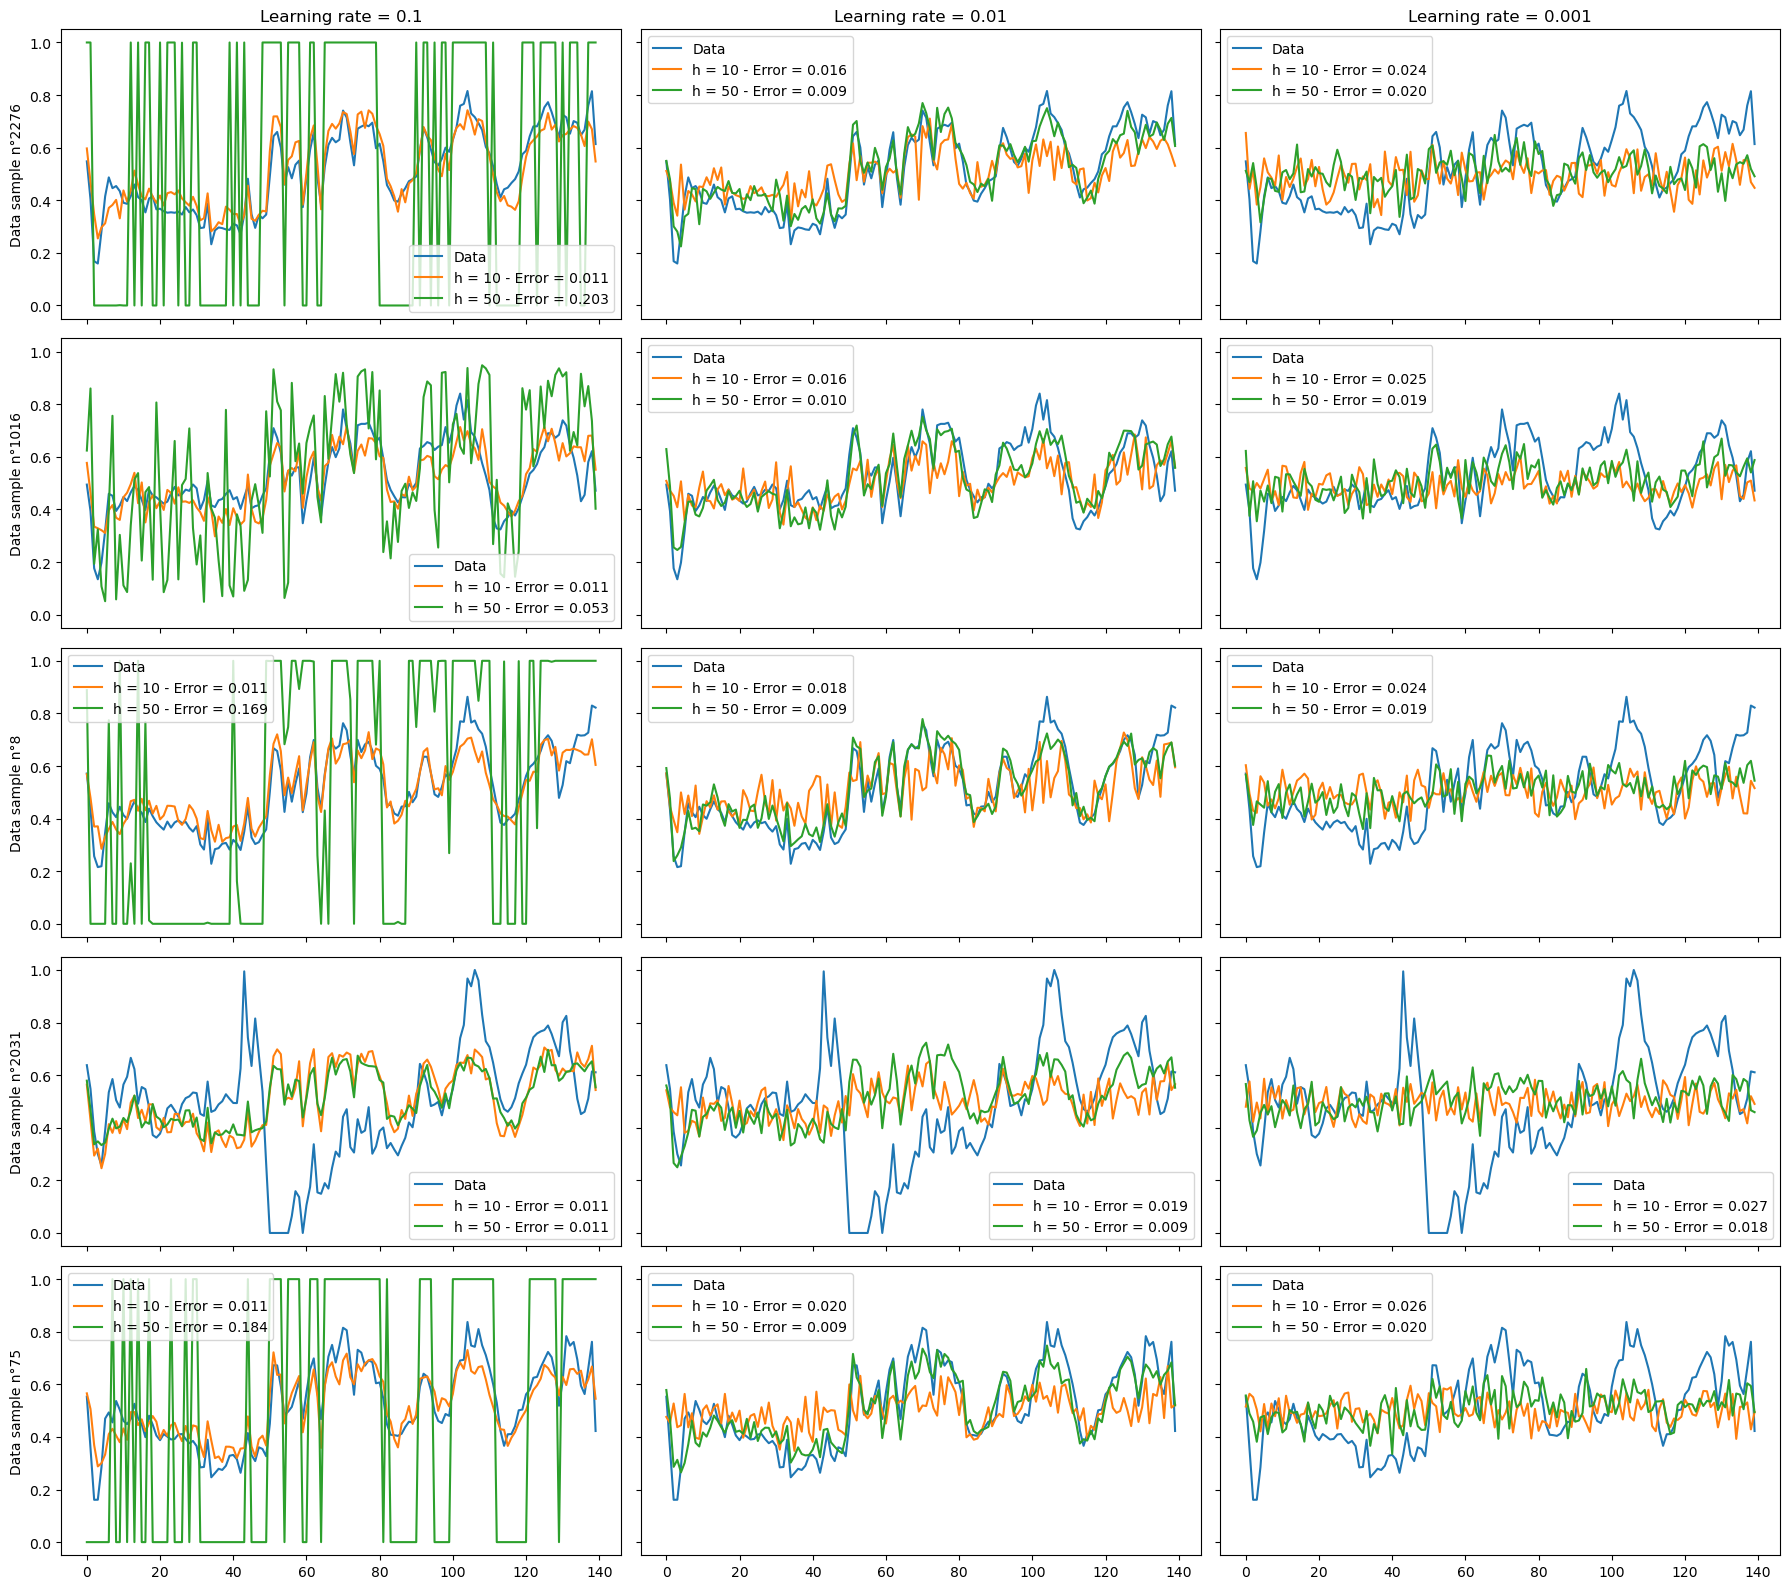

In [14]:
imids = np.random.choice(x_train.shape[0], 5)
plt.rcParams.update({"figure.figsize": (18, 16)})

lr = [0.1, 0.01, 0.001]
fig, ax = plt.subplots(5, 3, sharex=True, sharey=True)

for i in range(3):
    ax[0, i].set_title(f"Learning rate = {lr[i]}")
    for j in range(5):
        ax[j, 0].set_ylabel(f"Data sample n°{imids[j]}")

        ax[j, i].plot(x_train[imids[j]].detach().numpy(), label="Data")

        for h in [10, 50]:
            # Train the model :
            model = SimpleAE(input_size=x_train.shape[1], h=h)
            optimizer = th.optim.Adam(model.parameters(), lr=lr[i])
            train(model, epochs=10)
            output = model(x_train[imids[j]])

            # Compute the reconstruction error :
            good_idx_test = all_y_test[all_y_test == 1].index
            x_test_good = th.tensor(
                min_max_scaler.transform(all_x_test.loc[good_idx_test])
            ).float()
            loss = loss_fn(model, x_test_good)

            # Plot for original ECGs and reconstructed one :
            ax[j, i].plot(
                output.detach().numpy(), label=f"h = {h} - Error = {loss:.3f}"
            )
            ax[j, i].legend()

fig.tight_layout()

The image is a comparaison of having h = 10 or 50 hidden layers in the encoder with different learning rates (0.1, 0.01, 0.001). The graphs show the results for 5 randoms For each graph and each h, the error reconstruction is computed with the good EGCs datasets. With h = 50, if the learning rate is too high (l_r = 0.1), indeed, there are several reconstructions which are bad and are saturating, given a high reconstruction error (>>0.02, which is the limit we defined before), 10 times superior to the threshold we defined. But as we decreased the learning rate the problem disappear. Overall, 50 hidden layers offer a better reconstruction than 10 hidden layers when looking at the reconstruction error (2x smaller) with the right choosing learning rate (l_r = 0.001). If we decreased the learning rate too much, the model does not have the iteration needed to differentiate h = 10 from h = 50.

h = 50 and l_r = 0.001 to be the right combinaison here, more precise experiments could be made.


# Convolutional Auto-encoder

The input are time series. Like images, we can efficiently take into account the specifities of the inputs with convolutions: here it a time serie, we need 1D convolution.

The idea is:

- for the encoder use Conv1d, and pooling
- for the decoder, the opposite is ConvTranspose1d

Look at the documentation of Pytorch and design a convolutional Auto-encoder for ECGs.
Like images, you can either do several convolution in parallel but here you can also try to pipe them to reduce progressively the input dimenion.


In [215]:
class SimpleAE_C(nn.Module):
    def __init__(self, in_channels=1, out_channels=16):
        super(SimpleAE_C, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(
                in_channels=out_channels,
                out_channels=out_channels * 2,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(
                in_channels=out_channels * 2,
                out_channels=out_channels * 3,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=out_channels * 3,
                out_channels=out_channels * 2,
                kernel_size=2,
                stride=2,
                output_padding=1,
            ),
            nn.Sigmoid(),
            nn.ConvTranspose1d(
                in_channels=out_channels * 2,
                out_channels=out_channels * 1,
                kernel_size=2,
                stride=2,
            ),
            nn.ConvTranspose1d(
                in_channels=out_channels * 1, out_channels=1, kernel_size=2, stride=2
            ),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [142]:
# Train function adapted for the convolution
x_train_c = x_train.unsqueeze(
    1
)  # We need to add another dimension for the convolution channels


def train_C(model, epochs=10, verbose=False):
    for i in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, x_train_c)  # compute the loss
        loss.backward()  # Back propagation
        optimizer.step()  # update the parameters

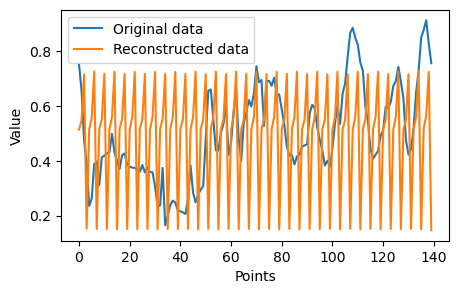

In [230]:
# This code is to compare the original data to the reconstructed one
model = SimpleAE_C()
lr = 0.01
optimizer = th.optim.Adam(model.parameters(), lr=lr)
train_C(model, epochs=10)
output = model(x_train_c[50])
plt.rcParams.update({"figure.figsize": (5, 3)})
plt.plot(x_train_c[50, 0].detach().numpy(), label="Original data")
plt.plot(output[0].detach().numpy(), label="Reconstructed data")
plt.xlabel("Points")
plt.ylabel("Value")
plt.legend()

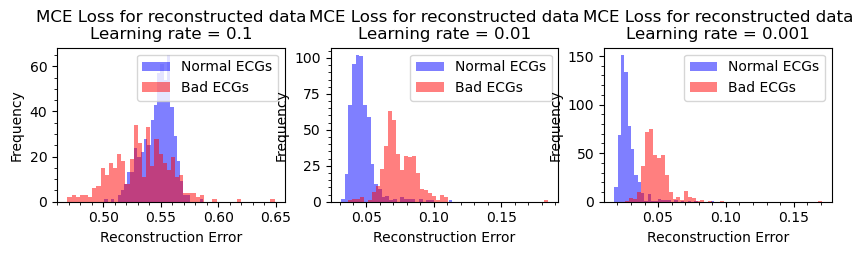

In [217]:
def test_histogram_C(model, lr, ax):
    # Preparation of data
    good_idx_test = all_y_test[all_y_test == 1].index
    bad_idx_test = all_y_test[all_y_test == 0].index
    x_test_good = (
        th.tensor(min_max_scaler.transform(all_x_test.loc[good_idx_test]))
        .unsqueeze(1)
        .float()
    )
    x_test_bad = (
        th.tensor(min_max_scaler.transform(all_x_test.loc[bad_idx_test]))
        .unsqueeze(1)
        .float()
    )

    loss_good = th.ones(x_test_good.shape[0])
    loss_bad = th.ones(x_test_bad.shape[0])

    # Computing loss
    for i in range(x_test_good.shape[0]):
        loss_good[i] = loss_fn(model, x_test_good[i])
    for i in range(x_test_bad.shape[0]):
        loss_bad[i] = loss_fn(model, x_test_bad[i])

    # Histogram
    ax.set_title(f"MCE Loss for reconstructed data\nLearning rate = {lr}")
    ax.hist(
        loss_good.detach().numpy(),
        bins=30,
        alpha=0.5,
        color="blue",
        label="Normal ECGs",
    )
    ax.hist(
        loss_bad.detach().numpy(), bins=50, alpha=0.5, color="red", label="Bad ECGs"
    )
    ax.set_xlabel("Reconstruction Error")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.minorticks_on()


# This code is for doing histograms
model = SimpleAE_C()
plt.rcParams.update({"figure.figsize": (10, 2)})
lr = [0.1, 0.01, 0.001]
fig, ax = plt.subplots(1, 3)
for i in range(3):
    optimizer = th.optim.Adam(model.parameters(), lr=lr[i])
    train_C(model, epochs=10)
    test_histogram_C(model, lr[i], ax[i])

In [220]:
# This code is to compute the different kind of errors :
model = SimpleAE_C()
# Train you model !
lr = 0.01
optimizer = th.optim.Adam(model.parameters(), lr=0.01)
train_C(model, epochs=10)

# Preparation of data
good_idx_test = all_y_test[all_y_test == 1].index
bad_idx_test = all_y_test[all_y_test == 0].index
x_test_good = (
    th.tensor(min_max_scaler.transform(all_x_test.loc[good_idx_test]))
    .unsqueeze(1)
    .float()
)
x_test_bad = (
    th.tensor(min_max_scaler.transform(all_x_test.loc[bad_idx_test]))
    .unsqueeze(1)
    .float()
)

loss_good = th.ones(x_test_good.shape[0])
loss_bad = th.ones(x_test_bad.shape[0])

# Calcul of loss for each sample :
for i in range(x_test_good.shape[0]):
    loss_good[i] = loss_fn(model, x_test_good[i])
for i in range(x_test_bad.shape[0]):
    loss_bad[i] = loss_fn(model, x_test_bad[i])

threshold = (
    th.sum(loss_bad) / loss_bad.shape[0]
    - (th.sum(loss_bad) / loss_bad.shape[0] - th.sum(loss_good) / loss_good.shape[0])
    / 2
)
print(f"threshold = {threshold}")
# threshold = 0.018

count_good_a = (loss_good < threshold).sum().item()  # Number of good ECGs accepted
count_bad_a = (loss_bad < threshold).sum().item()  # Number of bad ECGs accepted
count_good_r = (loss_good > threshold).sum().item()  # Number of good ECGs refused
count_bad_r = (loss_bad > threshold).sum().item()  # Number of bad ECGs refused


P_G_i_Gc = (
    count_good_a / Nvalid
)  # Probability to be classed normal ECGs and to be normal ECGs
P_B_i_Bc = count_bad_r / Nvalid  # Probability to be classed bad ECGs and to be bad ECGs
P_G_i_Bc = (
    count_good_r / Nvalid
)  # Probability to be classed bad ECGs and to be good ECGs
P_B_i_Gc = (
    count_bad_a / Nvalid
)  # Probability to be classed good ECGs and to be bad ECGs

print(f"Percentage of errors : {100*(P_G_i_Bc + P_B_i_Gc):2.1f}%")
print(f"Percentage of well classified : {100*(P_G_i_Gc + P_B_i_Bc):2.1f}%\n")

print(
    f"Percentage of bad EGCs classed good : {100*(count_bad_a/x_test_bad.shape[0]):2.1f}%"
)
print(
    f"Percentage of good EGCs classed bad : {100*(count_good_r/x_test_good.shape[0]):2.1f}%"
)

threshold = 0.19727995991706848
Percentage of errors : 8.0%
Percentage of well classified : 92.0%

Percentage of bad EGCs classed good : 9.9%
Percentage of good EGCs classed bad : 6.7%


The base of the Autoencoder using Convolution is planed following this :

```Python
class SimpleAE_C(nn.Module):
    def __init__(self, in_channels = 1, out_channels=16):
        super(SimpleAE_C, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=out_channels, out_channels=1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
```

The objective here is to improve this by adding more convolution layer without losing to much time by computing.
This basic scheme have this kind of errors for learning rate = 0.01 and threshold = 0.018:

Percentage of errors : 33.2%  
Percentage of well classified : 66.8%

Percentage of bad EGCs classed good : 3.6%  
Percentage of good EGCs classed bad : 54.3%

Seeing the histograms, we see that the two sets are not separated at all. We need to increase the discrimination by adding more convolution.

By adding a new convolution, we get to 80% of successfully classed data.

After a lot of testing, we managed to get a 92% accuracy with the model :
```Python
class SimpleAE_C(nn.Module):
    def __init__(self, in_channels = 1, out_channels=16):
        super(SimpleAE_C, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=out_channels, out_channels=out_channels*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=out_channels*2, out_channels=out_channels*3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=out_channels*3, out_channels=out_channels*2, kernel_size=2, stride=2, output_padding=1),
            nn.Sigmoid(),
            nn.ConvTranspose1d(in_channels=out_channels*2, out_channels=out_channels*1, kernel_size=2, stride=2),
            nn.ConvTranspose1d(in_channels=out_channels*1, out_channels=1, kernel_size=2, stride=2), 
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

```

92% with a threshold 0.19 does not mean it is good. Because in this experiment we get an error of bad EGCs attributed as good of 10% which is a lot. The threshold should be lowered.

We could continue to play with the parameters to try to find a better model, but it is quite difficult to distinguish the model more. This kind of model could be use in real life to detect bad EGCs but the threshold should be defined as suffisant to not have non-detected EGCs even if its mean having good ECGs passing as bad since we can do further tests afterwards.
